# Usando Regressão Linear para Explicar a votação de Deputados

Antes de tudo, é necessário fazer import dos frameworks que serão utilizados de forma a auxiliar a análise e manipulação dos dados, mas também os frameworks responsáveis por fazer a regressão linear em si.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder as le
from scipy.stats import normaltest
from plotly import plotly
import plotly.graph_objs as go
import itertools

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.model_selection import train_test_split as tts
from sklearn.linear_model import Lasso, Ridge
from sklearn.linear_model import LinearRegression as Linear
from sklearn.neighbors import KNeighborsRegressor as KNNR

In [3]:
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import AdaBoostRegressor as AdaBoost
from sklearn.ensemble import GradientBoostingRegressor as GradientBoosting
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor as RandomForest

In [4]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as rsquared

## Classes Auxiliares

Para auxiliar na verificação dos regressores e dos parâmetros de verificacão da regressão (MSE, RMSE, R-squared) e exemplificar os mesmos através de uma tabela, será definida uma classe auxiliar:

In [5]:
class MetricScores():
    def __init__(self, y_teste):
        self.y_teste = y_teste
        self.reset_df()
        
    def reset_df(self):
        colunas = ["Regressor", "p-1", "p-2", "p-3", "p-4", "p-5", "MSE", "RMSE", "R-Squared"]
        dic = dict((k, []) for k in colunas)
        self.metric_df = pd.DataFrame(dic)
        self.metric_df.columns = colunas
    
    def get_df(self):
        return self.metric_df
    
    def insert_regression(self, regressor_name, prediction, p1 = 0, p2 = 0, p3 = 0, p4 = 0, p5 = 0):
        new_row = {
            "Regressor": regressor_name, "p-1": p1,
            "p-2": p2, "p-3": p3, "p-4": p4, "p-5": p5,
            "MSE": mse(self.y_teste, prediction),
            "RMSE": (mse(self.y_teste, prediction) ** 0.5),
            "R-Squared": rsquared(self.y_teste, prediction)
        }
        self.metric_df.loc[1 + self.metric_df.shape[0]] = new_row

Além disso, é possível criar uma função reutilizável para fazer plotting comparando dois ou mais regressores:

In [6]:
def plotting_comparable_regression(regressor_list, dataset, target, title):
    if len(regressor_list) > 4:
        raise ValueError("The maximum number of regressors is 4.")
    colors = [
        "#a6cee3", "#1f78b4", "#b2df8a", "#33a02c", "#fb9a99", "#e31a1c",
        "#fdbf6f", "#ff7f00", "#cab2d6", "#6a3d9a", "#ffff99", "#b15928"
    ]
    x_train, x_test, y_train, y_test = tts(dataset, target)
    plt.figure(figsize=(20,10))
    for i in range(len(regressor_list)):
        regressor, label = regressor_list[i]
        regressor.fit(x_train, y_train)
        prediction = regressor.predict(x_test)
        
        sqr_err = np.square(np.subtract(prediction, y_test))
        mse = np.average(sqr_err)
        plt.scatter(range(len(sqr_err)), sqr_err, color=colors[i], label=label)
        plt.axhline(y = mse, color = colors[i])
    
    plt.title(title)
    plt.gca().set_yscale('log')
    plt.legend(loc="best")
    plt.show()

## Import dos dados

Tentamos importar os dados a partir do Google Drive, já que está sendo feito no Google Colaboratory. Caso não seja possível, importa-se os dados a partir da pasta local.

In [7]:
try:
  drv = 'drive/My Drive/CDP/'
  treino = pd.read_csv(drv + 'train_cat.csv')
  teste = pd.read_csv(drv + 'test_cat.csv')
except:
  parent = '../datasets/'
  treino = pd.read_csv(parent + 'train.csv')
  teste = pd.read_csv(parent + 'test.csv')

In [8]:
treino.head()

,ano,sequencial_candidato,nome,uf,partido,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos.comites,...,quantidade_despesas,quantidade_fornecedores,total_despesa,media_despesa,cargo,sexo,grau,estado_civil,ocupacao,votos
0,2006,10001,JOSÉ LUIZ NOGUEIRA DE SOUSA,AP,PT,6,6,16600.00,2766.67,0.0,...,14,14,16583.60,1184.54,DEPUTADO FEDERAL,MASCULINO,ENSINO MÉDIO COMPLETO,CASADO(A),VEREADOR,8579
1,2006,10002,LOIVA DE OLIVEIRA,RO,PT,13,13,22826.00,1755.85,6625.0,...,24,23,20325.99,846.92,DEPUTADO FEDERAL,FEMININO,SUPERIOR COMPLETO,SOLTEIRO(A),SERVIDOR PÚBLICO ESTADUAL,2757
2,2006,10002,MARIA DALVA DE SOUZA FIGUEIREDO,AP,PT,17,16,158120.80,9301.22,2250.0,...,123,108,146011.70,1187.09,DEPUTADO FEDERAL,FEMININO,SUPERIOR COMPLETO,VIÚVO(A),PEDAGOGO,17428
3,2006,10002,ROMALDO MILANI,MS,PRONA,6,6,3001.12,500.19,0.0,...,8,8,3001.12,375.14,DEPUTADO FEDERAL,MASCULINO,ENSINO MÉDIO INCOMPLETO,CASADO(A),MILITAR REFORMADO,1193
4,2006,10003,ANSELMO DE JESUS ABREU,RO,PT,48,48,119820.00,2496.25,0.0,...,133,120,116416.64,875.31,DEPUTADO FEDERAL,MASCULINO,ENSINO FUNDAMENTAL COMPLETO,CASADO(A),DEPUTADO,29401


## Análise dos dados
Como analisaremos os dados de treino, é necessário criar funções que sejam reutilizáveis, para permitir que o mesmo procedimento seja realizado em novas etapas do código. Inicialmente, analisaremos a distribuição das variáveis numéricas com a função `analisa_numericas`, aplicando a normalização nos casos necessários, vistos posteriormente.

Além dos gráficos, será feita uma verificação matemática para gerar um array no qual serão definidas as variáveis que devem ser normalizadas nos dados de treino e de teste: 
considera-se a hipótese de que o array segue uma distribuição normal e define-se um limite `alpha=0.0001` ; caso o resultado do teste de normalidade for menor que alpha, a hipótese de seguir a distribuição normal é rejeitada, isto é, os dados não seguem uma distribuição normal.

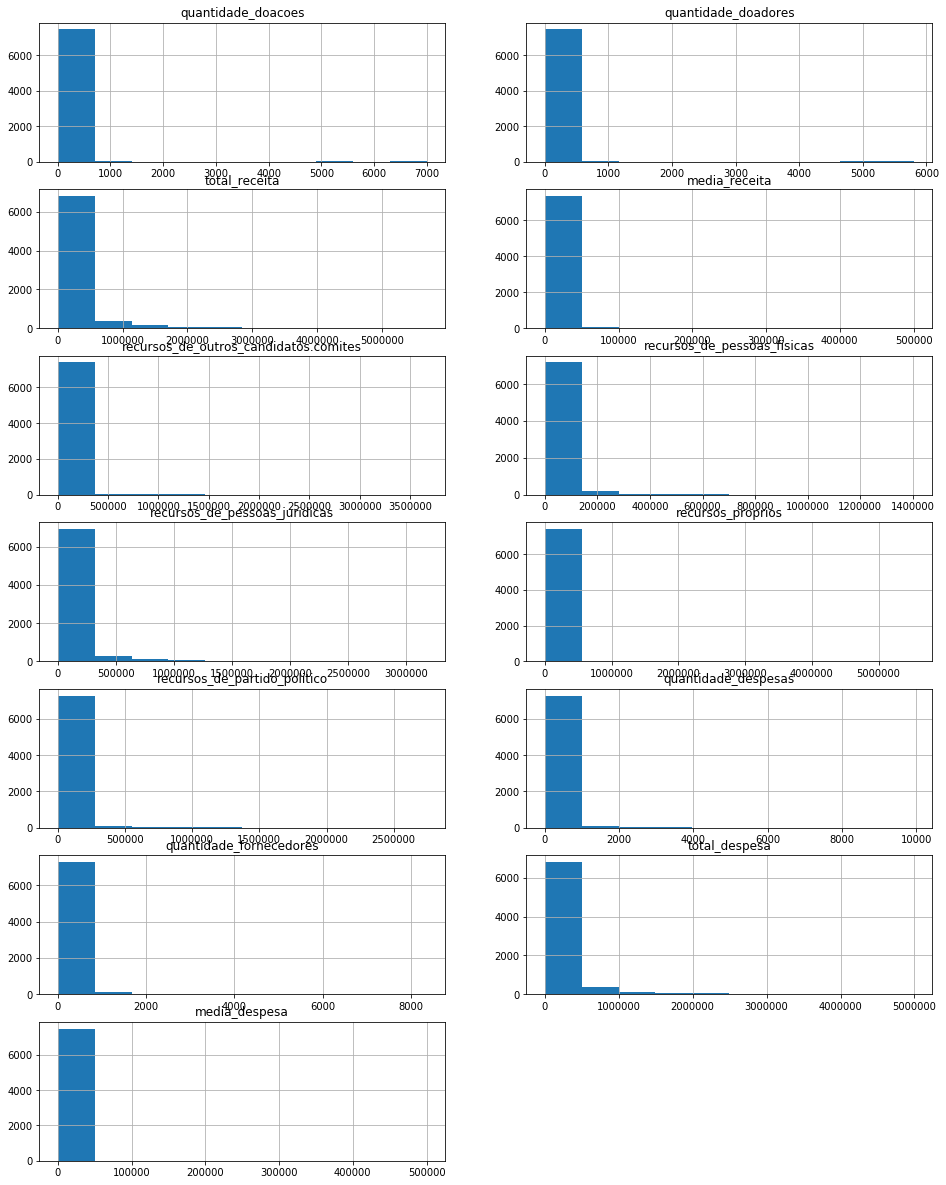

In [9]:
def is_numerico(coluna):
  valor = coluna.ravel()[0]
  numericos = [np.float64, np.float32, np.int64]
  for n in numericos:
    if isinstance(valor, n):
      return True
  return False
  
def analisa_numericas(df):
  plt.figure(figsize=(16,24))
  plt.title('Análise das variáveis')

  col_numericas = []
  col_nao_normais = []
  alpha = 1e-3
  
  for coluna in list(df):
    if is_numerico(df[coluna]) and coluna != "ano" and coluna != "sequencial_candidato" and coluna != "votos":
      col_numericas.append(coluna)
      if normaltest(df[coluna])[1] < alpha:
        col_nao_normais.append(coluna)
        
  for i in range(len(col_numericas)):
    coluna = col_numericas[i]
    plt.subplot(round(len(col_numericas)/2.0)+1, 2, i+1)
    plt.title(coluna)
    df[coluna].hist()
  plt.show()
  
  return col_nao_normais
  
colunas = analisa_numericas(treino)

## Manipulação dos Dados

A partir da análise dos gráficos acima, podemos identificar as colunas numéricas que possuem seus dados normalizados, e por isso criaremos a função `normaliza_dados`,  que normaliza todas as colunas recebidas e, ao fim, repete a análise gráfica feita acima.

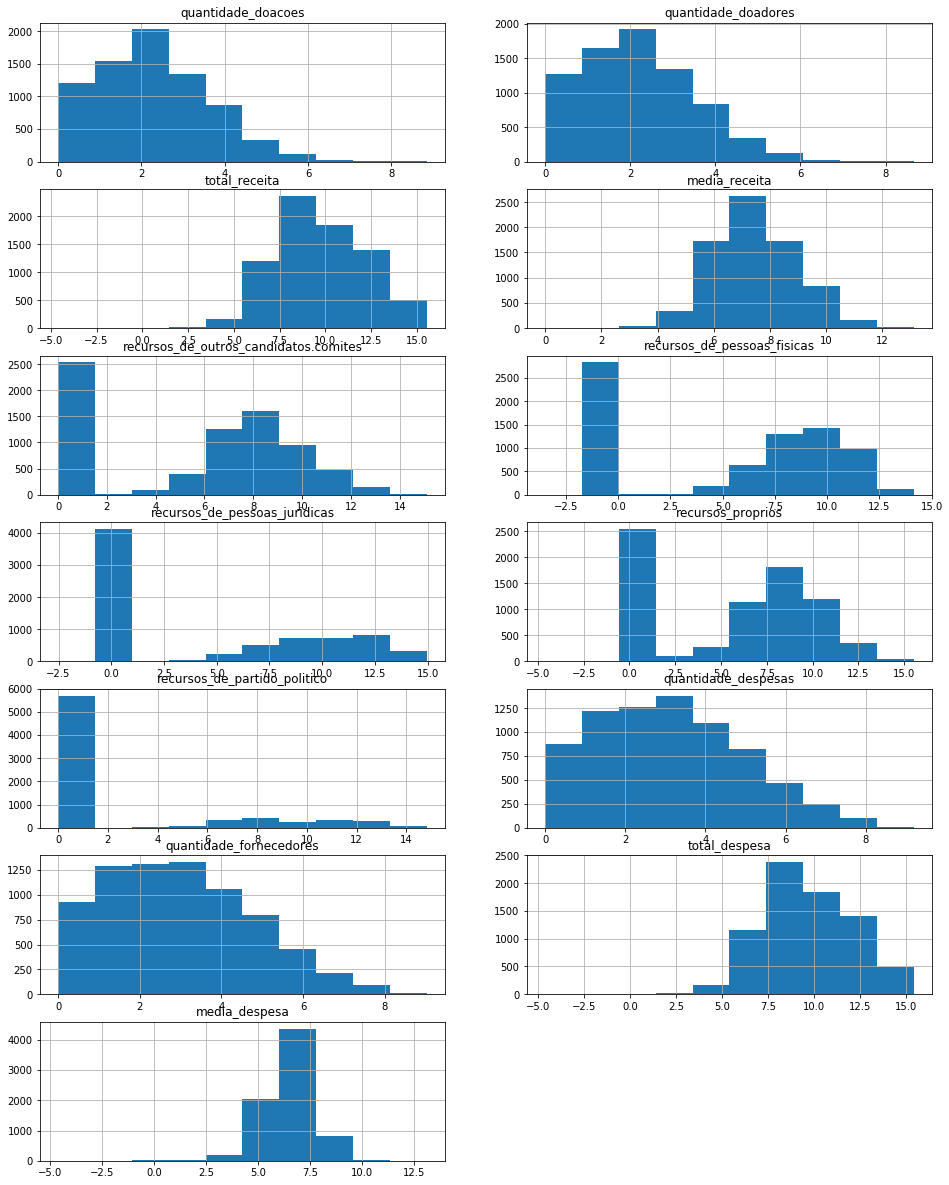

In [10]:
def normaliza_dados(df, colunas, analisa=True):
  for col in colunas:
    temp = df[col][:].apply(np.log).values
    temp[temp == np.inf] = 0
    temp[temp == -np.inf] = 0
    temp[temp == np.nan] = 0
    df[col] = temp
  if (analisa):
    analisa_numericas(df)
    
  return df

treino = normaliza_dados(treino, colunas)
teste = normaliza_dados(teste, colunas, analisa = False)

Algumas colunas, entretanto, não tem muito valor à regressão, muitas vezes chegando a atrapalhar o processo. Como as colunas "Nome" e "Ocupação" do candidato são colunas bastante diversificadas e que não seguram nenhum padrão evidente quanto aos dados, elas serão desconsiderardas na análise:

In [11]:
try:
  treino = treino.drop('ocupacao', axis=1)
  teste = teste.drop('ocupacao', axis=1)
  treino = treino.drop('nome', axis=1)
  teste = teste.drop('nome', axis=1)
except:
  pass

Em seguida, transformamos todas as colunas de fatores em variáveis dummy

In [12]:
def transforma_fatores(df):
  fatores = ['ano', 'uf', 'partido', 'cargo', 'sexo', 'estado_civil']
  for fator in fatores:
    df = pd.concat([df, pd.get_dummies(df[fator])], axis=1)
    df = df.drop(fator, axis=1)
  return df

treino = transforma_fatores(treino)
teste = transforma_fatores(teste)

Como a escolaridade é um fator que, quanto maior, mais impacto, a codificamos de uma forma diferente, seguindo a função abaixo.

In [13]:
def codifica(df, col_nome, mapa):
  nova_coluna = []

  for i, row in df.iterrows():
    nova_coluna.append(mapa[row[col_nome]])

  df[col_nome] = nova_coluna
  return df

def codifica_escolaridade(df):
  niv_escolaridade = {'LÊ E ESCREVE': 0, 'ENSINO FUNDAMENTAL INCOMPLETO': 1,
                      'ENSINO FUNDAMENTAL COMPLETO': 2,
                      'ENSINO MÉDIO INCOMPLETO': 3, 'ENSINO MÉDIO COMPLETO': 4,
                      'SUPERIOR INCOMPLETO': 5, 'SUPERIOR COMPLETO': 6 }
  return codifica(df, 'grau', niv_escolaridade)

treino = codifica_escolaridade(treino)
teste = codifica_escolaridade(teste)

### Padronização

Antes de iniciar o treino, é necessário padronizar os dados entre o conjunto de treino e de testes:

In [14]:
def append_dummy_zeros(dataframe, nome_coluna):
  dataframe[nome_coluna] = pd.Series([0 for i in range(len(dataframe))])
  return dataframe

for key in teste.keys():
  try:
    treino[key]
  except:
    treino = append_dummy_zeros(treino, key)

for key in treino.keys():
  try:
    teste[key]
  except:
    if (key != 'votos'):
      teste = append_dummy_zeros(teste, key)

## Treino

A partir desse momento, iniciam-se as manipulações finais nos dados e dá-se início ao treino.

In [15]:
x, y = treino.drop('votos', axis=1), treino['votos']
x_id = x.drop('sequencial_candidato', axis=1)
x_treino, x_teste, y_treino, y_teste = tts(x_id, y)
metric_scores = MetricScores(y_teste)

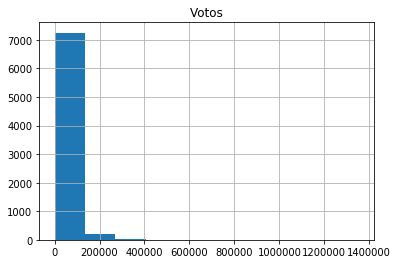

In [16]:
y.hist()
plt.title("Votos")
plt.show()

A partir do gráfico acima, que mostra a quantidade de candidatos (Y) que receberam a quantidade de votos (X), é possível perceber que os valores não seguem uma distribuição normal. Olhando de outra perspectiva, através de um boxplot, temos:

In [17]:
boxplot = go.Box(y=y)
plotly.iplot([boxplot])

Pelo boxplot acima fica evidente a suspeita de que existe um enorme número de outliers, estes recebendo uma quantidade de votos extremamente acima da média.

## Regressão Linear

Inicialmente, tomaremos como escopo da nossa regressão, o modelo mais simples: Linear. Para isso, não é necessário tunar hiper-parâmetros ou verificar os dados, apenas iniciaremos nosso regressor e treinamos com os conjuntos de dados. Vejamos:

In [18]:
linear = Linear()
linear.fit(x_treino, y_treino)
prediction = linear.predict(x_teste)
metric_scores.insert_regression("Linear", prediction)

In [19]:
metric_scores.get_df()

,Regressor,p-1,p-2,p-3,p-4,p-5,MSE,RMSE,R-Squared
1,Linear,0.0,0.0,0.0,0.0,0.0,1.744356e+12,1.320741e+06,-847.360239


Para ambas as regressões, Lasso e Ridge, será feito um tunning dentre um conjunto de alphas que é definido abaixo:

In [20]:
alphas = np.logspace(-6, 1, 15)

### Regressão Lasso

Inicialmente iremos definir alguns parâmetros para treinar diversas regressões Lasso, e assim definir qual o melhor conjunto de parâmetros para a mesma, tunando o Regressor. Em seguida, podemos fazer uma comparação entre o regressor tunado e o regressor default, comparando o Erro Quadrático Médio (MSE) e a Raiz do Erro Quadrático Médio (RMSE).

In [21]:
%%capture
for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso.fit(x_treino, y_treino)
    prediction = lasso.predict(x_teste)
    metric_scores.insert_regression("Lasso", prediction, p1 = alpha)

In [22]:
metric_scores.get_df()

,Regressor,p-1,p-2,p-3,p-4,p-5,MSE,RMSE,R-Squared
1,Linear,0.000000,0.0,0.0,0.0,0.0,1.744356e+12,1.320741e+06,-847.360239
2,Lasso,0.000001,0.0,0.0,0.0,0.0,1.120270e+09,3.347043e+04,0.455161
3,Lasso,0.000003,0.0,0.0,0.0,0.0,1.120270e+09,3.347043e+04,0.455161
4,Lasso,0.000010,0.0,0.0,0.0,0.0,1.120270e+09,3.347043e+04,0.455161
5,Lasso,0.000032,0.0,0.0,0.0,0.0,1.120270e+09,3.347043e+04,0.455161
6,Lasso,0.000100,0.0,0.0,0.0,0.0,1.120270e+09,3.347043e+04,0.455161
7,Lasso,0.000316,0.0,0.0,0.0,0.0,1.120270e+09,3.347043e+04,0.455161
8,Lasso,0.001000,0.0,0.0,0.0,0.0,1.120270e+09,3.347044e+04,0.455161
9,Lasso,0.003162,0.0,0.0,0.0,0.0,1.120270e+09,3.347044e+04,0.455161
10,Lasso,0.010000,0.0,0.0,0.0,0.0,1.120270e+09,3.347044e+04,0.455161


In [23]:
%%capture
best_alpha_index = metric_scores.get_df()["R-Squared"].argmax()
best_alpha = metric_scores.get_df().loc[[best_alpha_index]]["p-1"]
best_alpha = best_alpha.get_values()[0]

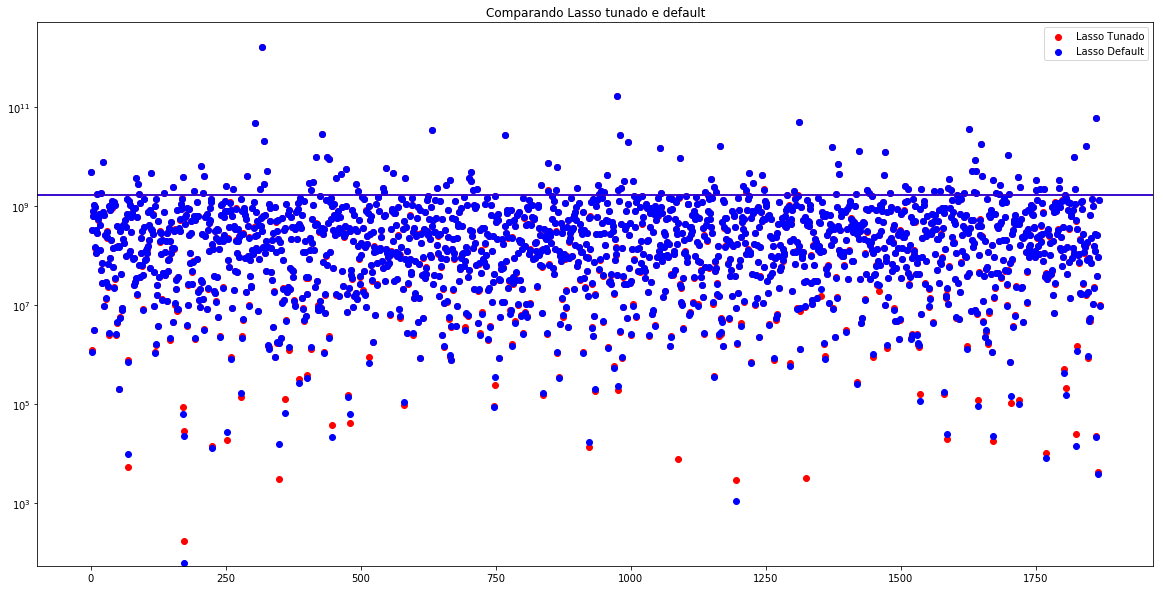

In [24]:
lasso_regressors = [(Lasso(alpha=best_alpha), "Lasso Tunado"), (Lasso(), "Lasso Default")]
plotting_comparable_regression(lasso_regressors, x_id, y, "Comparando Lasso tunado e default")

Como podemos ver no gráfico acima, o erro do valor predito é próximo entre a Regressão Lasso com a penalidade tunada e a Regressão Lasso default. Ambas possuem um alto Erro Quadrático Médio.

## Regressão Ridge

Agora, definiremos alguns parâmetros para treinar algumas regressões Ridge, e assim definir qual o melhor conjunto de parâmetros para a mesma, tunando o Regressor. Em seguida, podemos fazer uma comparação entre o regressor tunado e o regressor default, comparando o Erro Quadrático Médio (MSE) e a Raiz do Erro Quadrático Médio (RMSE).

In [25]:
for alpha in alphas:
    ridge = Ridge(alpha = alpha)
    ridge.fit(x_treino, y_treino)
    prediction = ridge.predict(x_teste)
    metric_scores.insert_regression("Ridge", prediction, p1 = alpha)

In [26]:
metric_scores.get_df()[metric_scores.get_df().Regressor == "Ridge"]

,Regressor,p-1,p-2,p-3,p-4,p-5,MSE,RMSE,R-Squared
17,Ridge,0.000001,0.0,0.0,0.0,0.0,1.389747e+12,1.178875e+06,-674.897624
18,Ridge,0.000003,0.0,0.0,0.0,0.0,9.157440e+11,9.569452e+05,-444.368391
19,Ridge,0.000010,0.0,0.0,0.0,0.0,3.607934e+11,6.006608e+05,-174.470413
20,Ridge,0.000032,0.0,0.0,0.0,0.0,7.718460e+10,2.778212e+05,-36.538416
21,Ridge,0.000100,0.0,0.0,0.0,0.0,1.162592e+10,1.078236e+05,-4.654220
22,Ridge,0.000316,0.0,0.0,0.0,0.0,2.346149e+09,4.843706e+04,-0.141040
23,Ridge,0.001000,0.0,0.0,0.0,0.0,1.265852e+09,3.557882e+04,0.384358
24,Ridge,0.003162,0.0,0.0,0.0,0.0,1.141421e+09,3.378492e+04,0.444874
25,Ridge,0.010000,0.0,0.0,0.0,0.0,1.124923e+09,3.353987e+04,0.452898
26,Ridge,0.031623,0.0,0.0,0.0,0.0,1.122027e+09,3.349668e+04,0.454306


In [27]:
best_alpha_index = metric_scores.get_df()[metric_scores.get_df().Regressor == "Ridge"]["R-Squared"].argmax()
best_alpha = metric_scores.get_df()[metric_scores.get_df().Regressor == "Ridge"].loc[[best_alpha_index]]["p-1"]
best_alpha = best_alpha.get_values()[0]

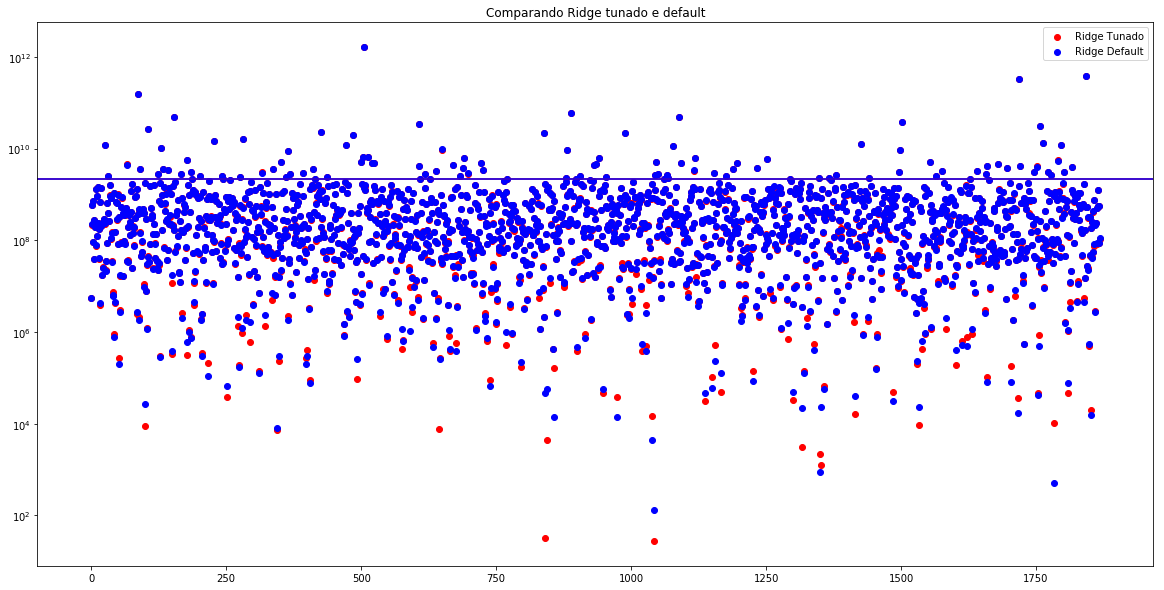

In [28]:
ridge_regressors = [(Ridge(alpha=best_alpha), "Ridge Tunado"), (Ridge(), "Ridge Default")]
plotting_comparable_regression(ridge_regressors, x_id, y, "Comparando Ridge tunado e default")

Pelo gráfico, bem como no gráfico da regressão Lasso, mas agora considerando a regressão Ridge, é possível notar que não existe grande diferença entre os valores preditos entre o regressor com alpha tunado e o regressor default.

## Regressor KNN

In [29]:
k = [1, 2, 5, 10, 15]
distances = [1, 2]
knn_params = [k, distances]

In [30]:
for ki, di in itertools.product(*knn_params):
    knn = KNNR(n_neighbors = ki, p = di)
    knn.fit(x_treino, y_treino)
    prediction = knn.predict(x_teste)
    metric_scores.insert_regression("KNN", prediction, p1=ki, p2=di)

In [31]:
best_knn_index = metric_scores.get_df()[metric_scores.get_df().Regressor == "KNN"]["R-Squared"].argmax()
best_knn = metric_scores.get_df()[metric_scores.get_df().Regressor == "KNN"].loc[[best_knn_index]]
best_k = int(best_knn["p-1"].get_values()[0])
best_p = int(best_knn["p-2"].get_values()[0])

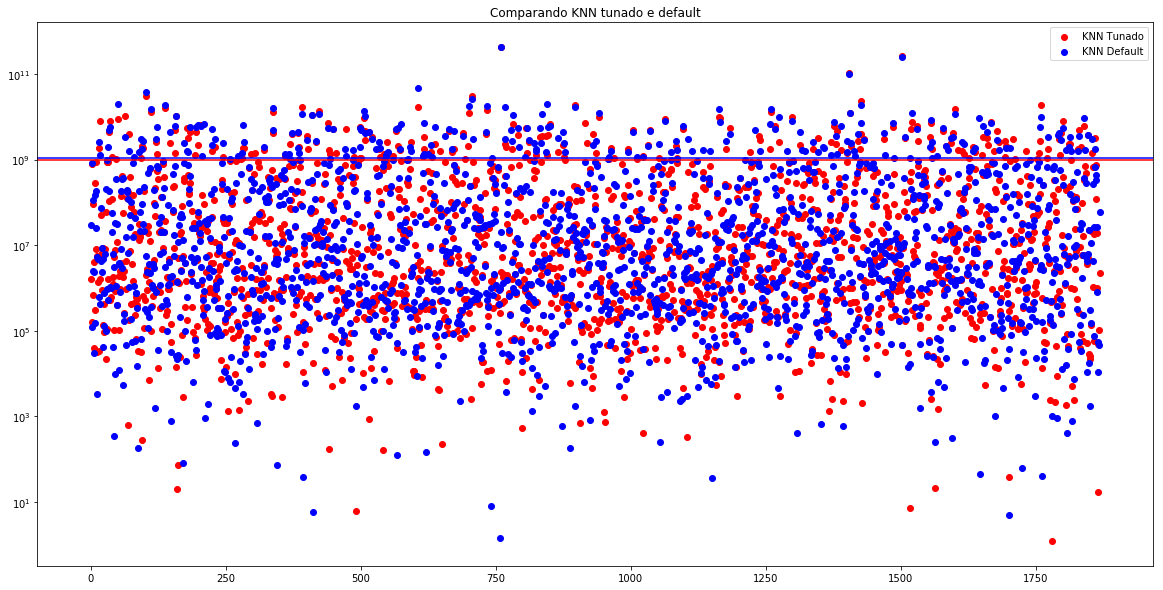

In [32]:
knn_regressors = [(KNNR(n_neighbors = best_k, p = best_p), "KNN Tunado"), (KNNR(), "KNN Default")]
plotting_comparable_regression(knn_regressors, x_id, y, "Comparando KNN tunado e default")

Como é possível notar, o KNN mostra resultados melhores que os regressores anteriores quando tunado. O Erro Quadrático Médio (MSE) quando tunado, ainda que próximo, é inferior ao MSE default do KNN, mostrando melhora significativa.

## Outros Regressores:
### ElasticNet Regressor

O regressor ElasticNet realiza uma regressão através do balanceamento entre os coeficientes L1, utilizado na Regressão Lasso, e L2, utilizado na Regressão Ridge. Através dessa combinação, cujo fator deve ser encontrado tunando o parâmetro de proporção dos coeficientes:

In [33]:
ratios = [e/100.0 for e in xrange(0, 100, 5)]
elastic_parameters = [alphas, ratios]

In [34]:
for a, r in itertools.product(*elastic_parameters):
    elastic = ElasticNet(alpha = a, l1_ratio = r)
    elastic.fit(x_treino, y_treino)
    predicted = elastic.predict(x_teste)
    metric_scores.insert_regression("ElasticNet", prediction, p1=a, p2=r)

In [35]:
best_elastic_index = metric_scores.get_df()[metric_scores.get_df().Regressor == "ElasticNet"]["R-Squared"].argmax()
best_elastic = metric_scores.get_df()[metric_scores.get_df().Regressor == "ElasticNet"].loc[[best_elastic_index]]
best_alpha = int(best_knn["p-1"].get_values()[0])
best_ratio = int(best_knn["p-2"].get_values()[0])

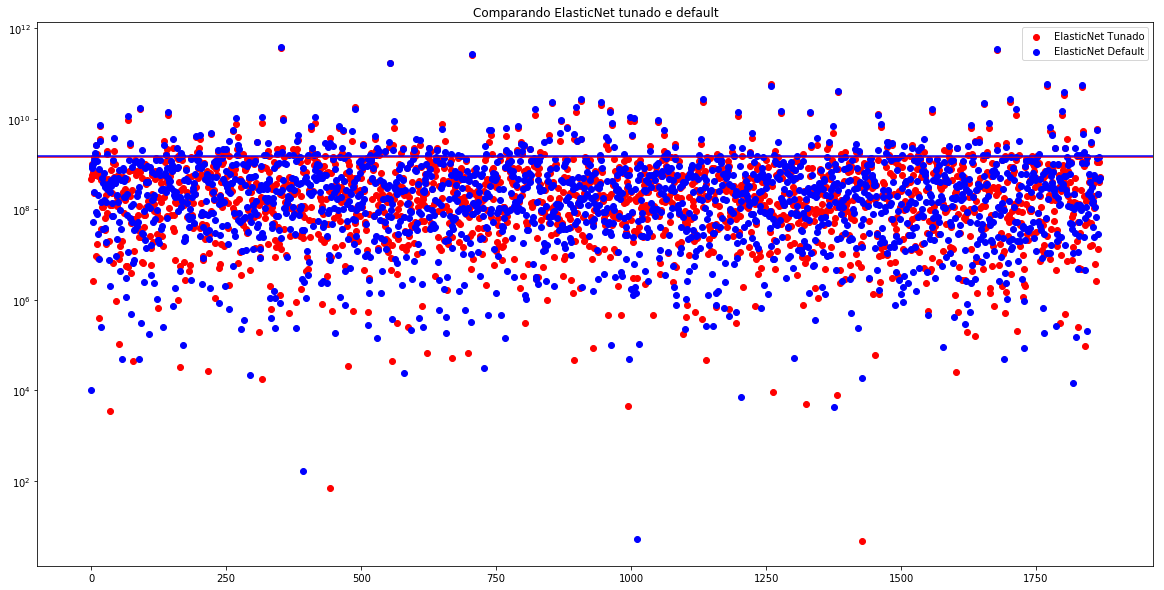

In [36]:
elastic_regressors = [(ElasticNet(alpha = best_alpha, l1_ratio = best_ratio), "ElasticNet Tunado"),
                      (ElasticNet(), "ElasticNet Default")]
plotting_comparable_regression(elastic_regressors, x_id, y, "Comparando ElasticNet tunado e default")

### AdaBoost Regressor

O regressor AdaBoost utiliza uma combinação de regressores simples para gerar uma regressão complexa a partir da combinação de regressores simples. O regressor simples que utilizaremos será uma Árvore de Decisão para regressão. Vejamos:

In [37]:
dt_depth = [3, 5]
dt_criterion = ['mse', 'mae']
n_estimators = [75, 100, 125, 150]
losses = ['linear', 'square']
ada_params = [dt_depth, dt_criterion, n_estimators, losses]

In [39]:
i = 0
for d, c, n, l in itertools.product(*ada_params):
    b = DecisionTreeRegressor(criterion = c, max_depth=d)
    ada = AdaBoost(base_estimator=b, loss=l, n_estimators=n)
    ada.fit(x_treino, y_treino)
    prediction = ada.predict(x_teste)
    metric_scores.insert_regression("AdaBoost", prediction, p1=d, p2=c, p3=n, p4=l)

In [40]:
best_ada_index = metric_scores.get_df()[metric_scores.get_df().Regressor == "AdaBoost"]["R-Squared"].argmax()
best_ada = metric_scores.get_df()[metric_scores.get_df().Regressor == "AdaBoost"].loc[[best_ada_index]]
best_depth = int(best_ada["p-1"].get_values()[0])
best_criterion = best_ada["p-2"].get_values()[0]
best_n = int(best_ada["p-3"].get_values()[0])
best_loss = best_ada["p-4"].get_values()[0]

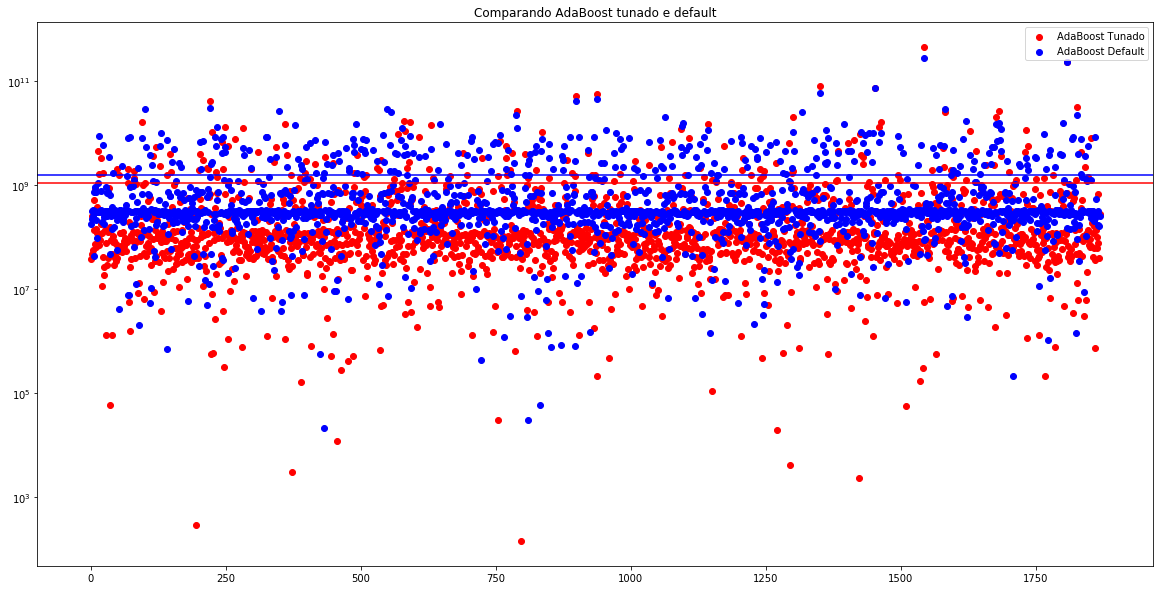

In [43]:
ada_regressors = [(AdaBoost(base_estimator=DecisionTreeRegressor(criterion=best_criterion, max_depth=best_depth),
                            loss = best_loss, n_estimators=best_n), "AdaBoost Tunado"),(AdaBoost(), "AdaBoost Default")]
plotting_comparable_regression(ada_regressors, x_id, y, "Comparando AdaBoost tunado e default")

#### The Road So Far

Na estrada até aqui, passamos pelas regressões Linear, Lasso, Ridge, KNN, ElasticNet e AdaBoost. Tendo um sumário do que esses regressores significam, podemos observar que:

In [46]:
result = metric_scores.get_df()
ind = result[result.Regressor == "Linear"]["R-Squared"].argmax()
linear = result.loc[[ind]]
ind = result[result.Regressor == "Lasso"]["R-Squared"].argmax()
lasso = result.loc[[ind]]
ind = result[result.Regressor == "Ridge"]["R-Squared"].argmax()
ridge = result.loc[[ind]]
ind = result[result.Regressor == "KNN"]["R-Squared"].argmax()
knn = result.loc[[ind]]
ind = result[result.Regressor == "ElasticNet"]["R-Squared"].argmax()
elastic = result.loc[[ind]]
ind = result[result.Regressor == "AdaBoost"]["R-Squared"].argmax()
ada = result.loc[[ind]]

In [48]:
dic = dict((k, []) for k in result.columns)
res = pd.DataFrame(dic)
res.columns = result.columns
res = res.append([linear, lasso, ridge, knn, elastic, ada])

In [49]:
res

,Regressor,p-1,p-2,p-3,p-4,p-5,MSE,RMSE,R-Squared
1,Linear,0.000000,0,0.0,0,0.0,1.744356e+12,1.320741e+06,-847.360239
2,Lasso,0.000001,0,0.0,0,0.0,1.120270e+09,3.347043e+04,0.455161
30,Ridge,3.162278,0,0.0,0,0.0,1.121067e+09,3.348235e+04,0.454773
38,KNN,10.000000,1,0.0,0,0.0,8.994857e+08,2.999143e+04,0.562539
42,ElasticNet,0.000001,0,0.0,0,0.0,9.629376e+08,3.103124e+04,0.531679
369,AdaBoost,5.000000,mae,100.0,square,0.0,9.460153e+08,3.075736e+04,0.539909


### Gradient Boosting Regressor

In [ ]:
metric_scores.get_df()

### Random Forest Regressor